In [5]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras import Input
from tensorflow.keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import time
import os

import mediapipe as mp
mpDraw = mp.solutions.drawing_utils
mpPose = mp.solutions.pose
pose = mpPose.Pose()

In [191]:
def extract_keypoints(results):
    lms = str(results.pose_landmarks).split("}\nlandmark {")

    lms[0] = lms[0][10:]
    lms[-1] = lms[-1][0:-2]
    kps = []

    for i in lms:
        row = i.split("\n")[1:-1]
        floatrow = []
        floatrow.append(float(row[0][5:]))
        floatrow.append(float(row[1][5:]))
#         z coords(not necessary)
#         floatrow.append(float(row[2][5:]))
#         confidence(not necessary just assume theyre all correct for now)
#         floatrow.append(float(row[3][14:]))
        kps.append(floatrow)
    return kps

In [194]:
directory = os.fsencode('./Custom Dataset/')

X = []
Yfill = []

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if(filename != '.ipynb_checkpoints'):
        img = cv2.imread('Custom Dataset/'+filename)
        img = cv2.resize(img,(256,256))
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = pose.process(imgRGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        X.append(img)
        keypoints = extract_keypoints(results)
        Yfill.append(keypoints)

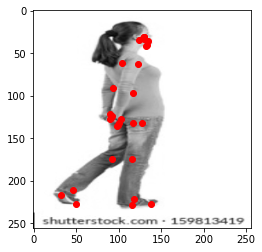

In [195]:
k= 6
for i in range(0,len(Yfill[0])):
    plt.plot(Yfill[k][i][0]*256,Yfill[k][i][1]*256, marker="o", color="red")
X[k].shape
plt.imshow(X[k],cmap='gray', vmin = 0, vmax = 255)

In [151]:
X = np.array(X)
X = X.reshape( len(X), 256, 256, 1)/255.0
Ytemp = np.array(Yfill)

In [152]:
# line up the xy coordinates simulataneously so it can be represented in the output dense layer of model x1y1x2y2x3y3...
Y = []
for i in range(0,len(Ytemp)):
    coords = []
    for j in range(0,len(Ytemp[0])):
        coords.append(Ytemp[i][j][0])
        coords.append(Ytemp[i][j][1])
    Y.append(coords)
Y = np.array(Y)

In [153]:
print(X.shape)
print(Y.shape)

(11, 256, 256, 1)
(11, 66)


In [154]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state = 47)

In [162]:
model = Sequential()
model.add(Input(shape = (256,256,1), dtype="float32"))

model.add(Conv2D(4,kernel_size=(5,5), strides=3, use_bias=True, activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(16,kernel_size=(3,3), strides=1, use_bias=True, activation='relu'))
model.add(Conv2D(32,kernel_size=(1,1), strides=1, use_bias=True, activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(64,kernel_size=(3,3), strides=1, use_bias=True, activation='relu'))
model.add(Conv2D(96,kernel_size=(1,1), strides=1, use_bias=True, activation='relu'))

model.add(AveragePooling2D(pool_size=(2,2), strides=2))

model.add(Flatten())

model.add(Dense(20, activation='relu'))

model.add(Dense(66, activation='linear'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 84, 84, 4)         104       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 42, 42, 4)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 40, 40, 16)        592       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 40, 40, 32)        544       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 18, 18, 64)        18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 18, 18, 96)       

In [163]:
model.compile( optimizer="adam" , loss="mse", metrics=['accuracy'])

In [164]:
model.fit(x_train, y_train, epochs=100, batch_size=5, validation_split=0.1)

Epoch 1/100
2/2 [==============================] - 0s 118ms/step - loss: 0.2322 - accuracy: 0.0000e+00 - val_loss: 0.2129 - val_accuracy: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 0s 24ms/step - loss: 0.2061 - accuracy: 0.0000e+00 - val_loss: 0.2034 - val_accuracy: 0.0000e+00
Epoch 3/100
2/2 [==============================] - 0s 24ms/step - loss: 0.1960 - accuracy: 0.0000e+00 - val_loss: 0.1987 - val_accuracy: 0.0000e+00
Epoch 4/100
2/2 [==============================] - 0s 26ms/step - loss: 0.1881 - accuracy: 0.0000e+00 - val_loss: 0.1934 - val_accuracy: 0.0000e+00
Epoch 5/100
2/2 [==============================] - 0s 26ms/step - loss: 0.1834 - accuracy: 0.0000e+00 - val_loss: 0.1863 - val_accuracy: 0.0000e+00
Epoch 6/100
2/2 [==============================] - 0s 23ms/step - loss: 0.1789 - accuracy: 0.0000e+00 - val_loss: 0.1798 - val_accuracy: 0.0000e+00
Epoch 7/100
2/2 [==============================] - 0s 24ms/step - loss: 0.1718 - accuracy: 0.0000e+00 - val_los

2/2 [==============================] - 0s 21ms/step - loss: 0.0103 - accuracy: 0.5714 - val_loss: 0.0212 - val_accuracy: 0.0000e+00
Epoch 57/100
2/2 [==============================] - 0s 19ms/step - loss: 0.0097 - accuracy: 0.5714 - val_loss: 0.0208 - val_accuracy: 0.0000e+00
Epoch 58/100
2/2 [==============================] - 0s 18ms/step - loss: 0.0092 - accuracy: 0.5714 - val_loss: 0.0206 - val_accuracy: 0.0000e+00
Epoch 59/100
2/2 [==============================] - 0s 19ms/step - loss: 0.0087 - accuracy: 0.5714 - val_loss: 0.0205 - val_accuracy: 0.0000e+00
Epoch 60/100
2/2 [==============================] - 0s 20ms/step - loss: 0.0083 - accuracy: 0.5714 - val_loss: 0.0204 - val_accuracy: 0.0000e+00
Epoch 61/100
2/2 [==============================] - 0s 19ms/step - loss: 0.0079 - accuracy: 0.5714 - val_loss: 0.0201 - val_accuracy: 0.0000e+00
Epoch 62/100
2/2 [==============================] - 0s 20ms/step - loss: 0.0075 - accuracy: 0.5714 - val_loss: 0.0200 - val_accuracy: 0.0000e+0

In [165]:
model.evaluate(x_test,y_test)

1/1 [==============================] - 0s 18ms/step - loss: 0.0053 - accuracy: 0.3333


[0.005258976947516203, 0.3333333432674408]

In [291]:
p = 0

In [292]:
inputX = np.array(x_train[p])
inputX = inputX.reshape(1,256,256,1)
prediction = model.predict(inputX)

In [293]:
print(prediction[0])
print(y_train[p])

[0.495261   0.16561309 0.47812018 0.13965811 0.50350255 0.12728962
 0.48907518 0.13914739 0.48903185 0.1395459  0.48142558 0.13955346
 0.45482028 0.13536626 0.519929   0.13486618 0.46179697 0.14456064
 0.5023661  0.1771039  0.48098302 0.1771687  0.5606816  0.24950327
 0.4192097  0.26096213 0.603807   0.39600745 0.41093796 0.41811785
 0.60235053 0.5071375  0.36307606 0.4947719  0.596949   0.5222566
 0.39036468 0.5565289  0.5888895  0.52843934 0.37425807 0.5060407
 0.5932123  0.5088963  0.39000785 0.5075698  0.54914373 0.5352395
 0.4609908  0.5365793  0.52259547 0.7320714  0.4443023  0.7277244
 0.5066152  0.90840626 0.4521948  0.8807818  0.5018991  0.93694276
 0.44581938 0.93680173 0.5185276  0.99485976 0.4245562  0.95641327]
[0.4891724  0.14065072 0.50080866 0.12292545 0.50867063 0.1225367
 0.51603556 0.12225804 0.47672758 0.12418669 0.46749505 0.12489479
 0.45962161 0.12548773 0.52898216 0.12912253 0.45235547 0.13338397
 0.50312501 0.15966737 0.47758076 0.16307014 0.58752668 0.24037994

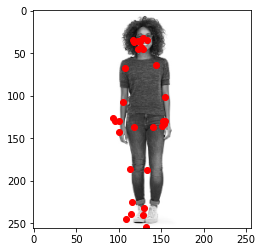

In [294]:
for i in range(0,int(len(prediction[0])/2)):
    plt.plot(prediction[0][i*2]*256,prediction[0][(i*2)+1]*256, marker="o", color="red")
    
testimg = x_train[p]*255
plt.imshow(testimg,cmap='gray', vmin = 0, vmax = 255)

In [295]:
cap = cv2.VideoCapture(0)
    
while(True):
    ret,img = cap.read()
    img = cv2.resize(img,(256,256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    input_image = np.array(img).reshape(1,256,256,1)
    prediction = model.predict(input_image)
    
    for i in range(0,int(len(prediction[0])/2)):
#         plt.plot(prediction[0][i*2]*256,prediction[0][(i*2)+1]*256, marker="o", color="red")
        cv2.circle(img, (int(prediction[0][i*2]*256), int(prediction[0][(i*2)+1]*256)), 4, (255,0,0),-1)

    
    cv2.imshow('Capturing Video', img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break


KeyboardInterrupt: 

In [234]:
cap.release()
cv2.destroyAllWindows()

In [239]:
img = cv2.imread('Custom Dataset/img1.jpg')
img = cv2.resize(img,(256,256))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
input_image = np.array(img).reshape(1,256,256,1)
print(input_image.shape)

(1, 256, 256, 1)
